In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import audioread
from pydub import AudioSegment
import soundfile as sf
import seaborn as sns


# Data Preprocessing


 Loading metadata

In [3]:
sentence_df = pd.read_csv('./CREMA-D-master/SentenceFilenames.csv')
demographics_df = pd.read_csv('./CREMA-D-master/VideoDemographics.csv')
ratings_df = pd.read_csv('./CREMA-D-master/processedResults/tabulatedVotes.csv')


In [4]:
print("Sentence Data:\n", sentence_df.head())
print("\nDemographics:\n", demographics_df.head())
print("\nRatings:\n", ratings_df.head())

Sentence Data:
    Stimulus_Number         Filename
0                1  1001_IEO_NEU_XX
1                2  1001_IEO_HAP_LO
2                3  1001_IEO_HAP_MD
3                4  1001_IEO_HAP_HI
4                5  1001_IEO_SAD_LO

Demographics:
    ActorID  Age     Sex              Race     Ethnicity
0     1001   51    Male         Caucasian  Not Hispanic
1     1002   21  Female         Caucasian  Not Hispanic
2     1003   21  Female         Caucasian  Not Hispanic
3     1004   42  Female         Caucasian  Not Hispanic
4     1005   29    Male  African American  Not Hispanic

Ratings:
    Unnamed: 0  A  D  F  H   N  S         fileName  numResponses  agreement  \
0      100001  0  0  0  1  10  0  1001_IEO_NEU_XX            11   0.909091   
1      100002  0  0  0  3   6  0  1001_IEO_HAP_LO             9   0.666667   
2      100003  0  0  0  4   7  0  1001_IEO_HAP_MD            11   0.636364   
3      100004  2  0  0  6   2  0  1001_IEO_HAP_HI            10   0.600000   
4      100005  

Loading Audio files

In [ ]:
import os

audio_folder = './CREMA-D-master/AudioWAV/'

audio_files = [f for f in os.listdir(audio_folder) if f.endswith(".wav")]
print(f"Total audio files found: {len(audio_files)}")


Total audio files found: 7443
Sample File: 1001_DFA_ANG_XX.wav
Original Sampling Rate: 16000
Audio Duration: 2.28 seconds


In [34]:
def extract_features(file_path):
    try:
        # Load audio
        y, sr = librosa.load(file_path, sr=16000)  # Resampling to 16kHz
        
        # MFCCs (Mel-Frequency Cepstral Coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfccs_mean = np.mean(mfccs, axis=1)

        # Pitch (Fundamental Frequency F0)
        f0, voiced_flag, _ = librosa.pyin(y, fmin=50, fmax=300)
        f0_mean = np.nanmean(f0) if np.any(~np.isnan(f0)) else 0

        # RMS Energy
        rms = librosa.feature.rms(y=y)
        rms_mean = np.mean(rms)

        # Zero-Crossing Rate (ZCR)
        zcr = librosa.feature.zero_crossing_rate(y)
        zcr_mean = np.mean(zcr)

        return [file_path, *mfccs_mean, f0_mean, rms_mean, zcr_mean]

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Create an empty list to store features
features_list = []

# Process all audio files
for file in audio_files:
    file_path = os.path.join(audio_folder, file)
    features = extract_features(file_path)
    if features:
        features_list.append(features)

# Convert to Pandas DataFrame
columns = ["filename"] + [f"mfcc_{i}" for i in range(40)] + ["f0_mean", "rms_mean", "zcr_mean"]
df_features = pd.DataFrame(features_list, columns=columns)

# Save extracted features to a CSV file
df_features.to_csv("audio_features.csv", index=False)
print("Feature extraction completed and saved to audio_features.csv!")


Error processing ./CREMA-D-master/AudioWAV/1040_ITH_SAD_XX.wav: module 'soundfile' has no attribute 'SoundFileRuntimeError'
Feature extraction completed and saved to audio_features.csv!


Compute clarity features:

In [36]:
df_features = pd.read_csv("./audio_features.csv")
df_features.head()

,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,mfcc_33,mfcc_34,mfcc_35,mfcc_36,mfcc_37,mfcc_38,mfcc_39,f0_mean,rms_mean,zcr_mean
0,./CREMA-D-master/AudioWAV/1001_DFA_ANG_XX.wav,-306.02740,92.670235,8.491312,23.965403,7.477993,-5.759456,-11.883088,-9.676736,-3.996746,...,-4.839286,-3.165155,-3.591552,-2.021887,-1.169516,0.621937,1.180276,0.000000,0.041986,0.101868
1,./CREMA-D-master/AudioWAV/1001_DFA_DIS_XX.wav,-346.39963,95.839120,10.516282,31.619215,15.872088,-6.845447,-6.629935,-4.978727,-5.310654,...,-2.173760,-1.994260,-1.597325,-2.791202,-1.645650,-1.667598,-2.196356,0.000000,0.015996,0.093061
2,./CREMA-D-master/AudioWAV/1001_DFA_FEA_XX.wav,-321.42026,94.760910,8.155397,23.323242,11.719157,-7.116331,-8.534803,-4.996965,-4.994400,...,-2.348613,-1.282330,-1.399008,-2.813862,0.508757,0.807889,-0.864563,0.000000,0.045776,0.084286
3,./CREMA-D-master/AudioWAV/1001_DFA_HAP_XX.wav,-303.30374,92.528890,4.231232,27.970133,10.869824,-11.878345,-10.095113,-7.149731,-7.651760,...,-1.571788,1.631128,1.487838,0.229535,3.201811,1.202342,0.137935,0.000000,0.042300,0.084878
4,./CREMA-D-master/AudioWAV/1001_DFA_NEU_XX.wav,-335.49590,100.393310,9.384935,30.160906,11.466775,-3.333670,-8.350987,-9.757346,-6.079327,...,-3.257390,-1.115127,-0.962948,-2.444529,-0.787875,-1.385394,-3.267120,212.781841,0.020450,0.082031


In [40]:
def calculate_mfcc_variance(df):
    mfcc_columns = [f"mfcc_{i}" for i in range(40)]
    df['mfcc_variance'] = df[mfcc_columns].var(axis=1)
    return df

def calculate_spectral_centroid(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        return np.mean(spectral_centroid)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

# Add Spectral Centroid to the DataFrame
df_features['spectral_centroid'] = df_features['filename'].apply(calculate_spectral_centroid)


# Let's assume it's proportional to the RMS energy variation.
def calculate_articulation_rate(file_path):
    try:
        y, sr = librosa.load(file_path, sr=16000)
        rms = librosa.feature.rms(y=y)
        articulation_rate = np.mean(rms)  # Simplified as RMS mean
        return articulation_rate
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return np.nan

# Add Articulation Rate to the DataFrame
df_features['articulation_rate'] = df_features['filename'].apply(calculate_articulation_rate)

# Calculate MFCC Variance
df_features = calculate_mfcc_variance(df_features)

# Display updated DataFrame with clarity features
df_features.head()


,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,...,mfcc_36,mfcc_37,mfcc_38,mfcc_39,f0_mean,rms_mean,zcr_mean,spectral_centroid,articulation_rate,mfcc_variance
0,./CREMA-D-master/AudioWAV/1001_DFA_ANG_XX.wav,-306.02740,92.670235,8.491312,23.965403,7.477993,-5.759456,-11.883088,-9.676736,-3.996746,...,-2.021887,-1.169516,0.621937,1.180276,0.000000,0.041986,0.101868,1584.993071,0.041986,2601.221881
1,./CREMA-D-master/AudioWAV/1001_DFA_DIS_XX.wav,-346.39963,95.839120,10.516282,31.619215,15.872088,-6.845447,-6.629935,-4.978727,-5.310654,...,-2.791202,-1.645650,-1.667598,-2.196356,0.000000,0.015996,0.093061,1531.650486,0.015996,3298.394774
2,./CREMA-D-master/AudioWAV/1001_DFA_FEA_XX.wav,-321.42026,94.760910,8.155397,23.323242,11.719157,-7.116331,-8.534803,-4.996965,-4.994400,...,-2.813862,0.508757,0.807889,-0.864563,0.000000,0.045776,0.084286,1489.088839,0.045776,2860.217517
3,./CREMA-D-master/AudioWAV/1001_DFA_HAP_XX.wav,-303.30374,92.528890,4.231232,27.970133,10.869824,-11.878345,-10.095113,-7.149731,-7.651760,...,0.229535,3.201811,1.202342,0.137935,0.000000,0.042300,0.084878,1555.376035,0.042300,2573.239369
4,./CREMA-D-master/AudioWAV/1001_DFA_NEU_XX.wav,-335.49590,100.393310,9.384935,30.160906,11.466775,-3.333670,-8.350987,-9.757346,-6.079327,...,-2.444529,-0.787875,-1.385394,-3.267120,212.781841,0.020450,0.082031,1495.394998,0.020450,3132.866056


Data Cleaning

filename    0
mfcc_0      0
mfcc_1      0
mfcc_2      0
mfcc_3      0
mfcc_4      0
mfcc_5      0
mfcc_6      0
mfcc_7      0
mfcc_8      0
mfcc_9      0
mfcc_10     0
mfcc_11     0
mfcc_12     0
mfcc_13     0
mfcc_14     0
mfcc_15     0
mfcc_16     0
mfcc_17     0
mfcc_18     0
mfcc_19     0
mfcc_20     0
mfcc_21     0
mfcc_22     0
mfcc_23     0
mfcc_24     0
mfcc_25     0
mfcc_26     0
mfcc_27     0
mfcc_28     0
mfcc_29     0
mfcc_30     0
mfcc_31     0
mfcc_32     0
mfcc_33     0
mfcc_34     0
mfcc_35     0
mfcc_36     0
mfcc_37     0
mfcc_38     0
mfcc_39     0
f0_mean     0
rms_mean    0
zcr_mean    0
dtype: int64
            mfcc_0       mfcc_1       mfcc_2       mfcc_3       mfcc_4  \
count  7442.000000  7442.000000  7442.000000  7442.000000  7442.000000   
mean   -351.141612   101.387476    32.527496    22.956191     5.605276   
std      54.715606    14.333944    14.050444     7.298027     8.606121   
min   -1131.371000     0.000000   -21.610441    -8.914308   -32.680992   
2

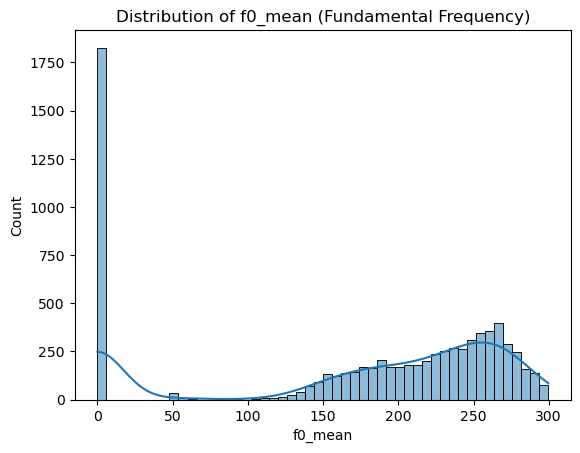

In [60]:
df = pd.read_csv("./audio_features.csv")

# Check for missing values
print(df.isnull().sum())

# Summary statistics
print(df.describe())

# Check correlations
df_numeric = df.drop(columns=['filename'])  # Remove filename column
correlation_matrix = df_numeric.corr()  # Compute correlation matrix
print(correlation_matrix)

# Visualizing feature distributions

sns.histplot(df['f0_mean'], bins=50, kde=True)
plt.title("Distribution of f0_mean (Fundamental Frequency)")
plt.show()


In [47]:
# Drop filename for numerical analysis
df_numeric = df.drop(columns=['filename'])

# Identify rows with zero pitch or energy
zero_pitch = df_numeric[df_numeric['f0_mean'] == 0]
zero_energy = df_numeric[df_numeric['rms_mean'] == 0]

print(f"Zero Pitch Count: {len(zero_pitch)}")
print(f"Zero Energy Count: {len(zero_energy)}")

# Detect outliers using IQR
Q1 = df_numeric.quantile(0.25)
Q3 = df_numeric.quantile(0.75)
IQR = Q3 - Q1

outliers = ((df_numeric < (Q1 - 1.5 * IQR)) | (df_numeric > (Q3 + 1.5 * IQR))).sum()
print("\nOutlier Count per Feature:")
print(outliers)


Zero Pitch Count: 1827
Zero Energy Count: 1

Outlier Count per Feature:
mfcc_0      137
mfcc_1      239
mfcc_2       76
mfcc_3       87
mfcc_4      136
mfcc_5       69
mfcc_6       97
mfcc_7       71
mfcc_8      148
mfcc_9      222
mfcc_10     106
mfcc_11     403
mfcc_12     147
mfcc_13     135
mfcc_14     275
mfcc_15     203
mfcc_16     150
mfcc_17     206
mfcc_18     238
mfcc_19     223
mfcc_20     261
mfcc_21     422
mfcc_22     207
mfcc_23     263
mfcc_24     237
mfcc_25     218
mfcc_26     219
mfcc_27     221
mfcc_28     172
mfcc_29     139
mfcc_30     183
mfcc_31     210
mfcc_32     174
mfcc_33     132
mfcc_34     154
mfcc_35     147
mfcc_36      94
mfcc_37     132
mfcc_38     157
mfcc_39     116
f0_mean       0
rms_mean    710
zcr_mean    432
dtype: int64


In [85]:
# Replace zero values in 'f0_mean' with the minimum non-zero pitch
min_f0 = df[df['f0_mean'] > 0]['f0_mean'].min()
df['f0_mean'] = df['f0_mean'].replace(0, min_f0)

# Alternatively, replace zero values in 'rms_mean' with the minimum non-zero RMS value
min_rms = df[df['rms_mean'] > 0]['rms_mean'].min()
df['rms_mean'] = df['rms_mean'].replace(0, min_rms)

# Define a function to filter out outliers based on IQR
def filter_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df
#df_filtered = filter_outliers(df, df.columns[1:])

def cap_outliers(df, cols, lower_percentile=0.05, upper_percentile=0.85):
    for col in cols:
        lower_bound = df[col].quantile(lower_percentile)
        upper_bound = df[col].quantile(upper_percentile)
        df[col] = np.clip(df[col], lower_bound, upper_bound)
    return df

# Apply filtering on MFCCs and other features with potential outliers
df_filtered = cap_outliers(df, df.columns[1:])  # Filtering all feature columns (excluding 'filename')


Original dataset shape: (7442, 49)
Filtered dataset shape: (7442, 49)


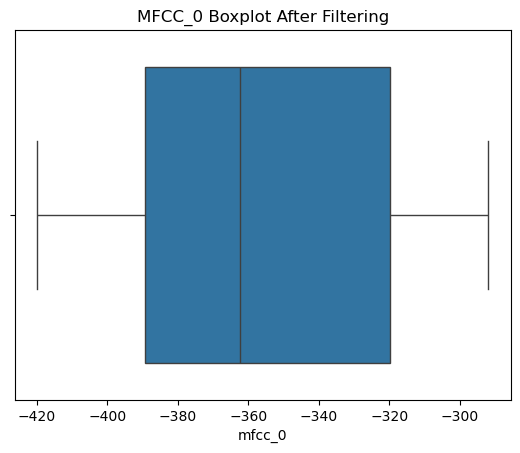

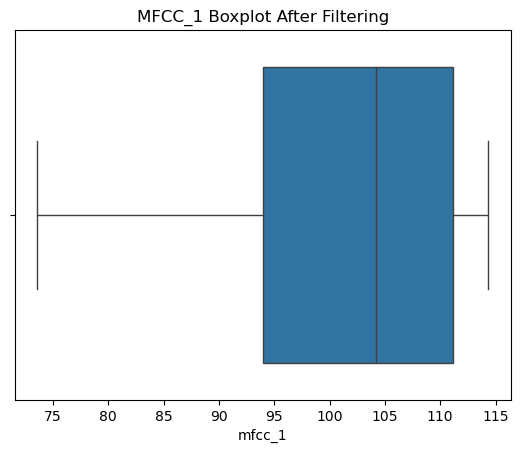

In [86]:
# Before filtering
print(f"Original dataset shape: {df.shape}")

# After filtering
print(f"Filtered dataset shape: {df_filtered.shape}")
sns.boxplot(x=df_filtered['mfcc_0'])
plt.title('MFCC_0 Boxplot After Filtering')
plt.show()

# Repeat for other features if needed
sns.boxplot(x=df_filtered['mfcc_1'])
plt.title('MFCC_1 Boxplot After Filtering')
plt.show()

Confidence features

In [87]:
# Calculate pitch variation (standard deviation of F0)
df_filtered['pitch_variation'] = df_filtered['f0_mean'].std()

# Calculate energy stability (standard deviation of RMS energy)
df_filtered['energy_stability'] = df_filtered['rms_mean'].std()


Fluency features

In [88]:
# Define a threshold for detecting pauses (e.g., RMS <= 0.01 is a pause)
pause_threshold = 0.01
df_filtered['pause_frequency'] = (df_filtered['rms_mean'] <= pause_threshold).sum()

# Calculate pause duration as the number of consecutive RMS values below the threshold
df_filtered['pause_duration'] = df_filtered['rms_mean'][df_filtered['rms_mean'] <= pause_threshold].count()

# Calculate speaking rate as the number of non-zero RMS values
df_filtered['speaking_rate'] = (df_filtered['rms_mean'] > pause_threshold).sum()


In [89]:
print(df_filtered[['filename', 'pitch_variation', 'energy_stability', 'pause_frequency', 'pause_duration', 'speaking_rate']].head())

                                        filename  pitch_variation  \
0  ./CREMA-D-master/AudioWAV/1001_DFA_ANG_XX.wav        83.123862   
1  ./CREMA-D-master/AudioWAV/1001_DFA_DIS_XX.wav        83.123862   
2  ./CREMA-D-master/AudioWAV/1001_DFA_FEA_XX.wav        83.123862   
3  ./CREMA-D-master/AudioWAV/1001_DFA_HAP_XX.wav        83.123862   
4  ./CREMA-D-master/AudioWAV/1001_DFA_NEU_XX.wav        83.123862   

   energy_stability  pause_frequency  pause_duration  speaking_rate  
0          0.014236             1416            1416           6026  
1          0.014236             1416            1416           6026  
2          0.014236             1416            1416           6026  
3          0.014236             1416            1416           6026  
4          0.014236             1416            1416           6026  
